# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os

import numpy as np

import torch
import torch.optim

import scipy.io
from skimage.measure import compare_psnr
from models.downsampler import Downsampler
from models.skip3D import skip

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor


/home/oleksii/miniconda3/envs/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/oleksii/miniconda3/envs/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/oleksii/miniconda3/envs/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Load image and baselines

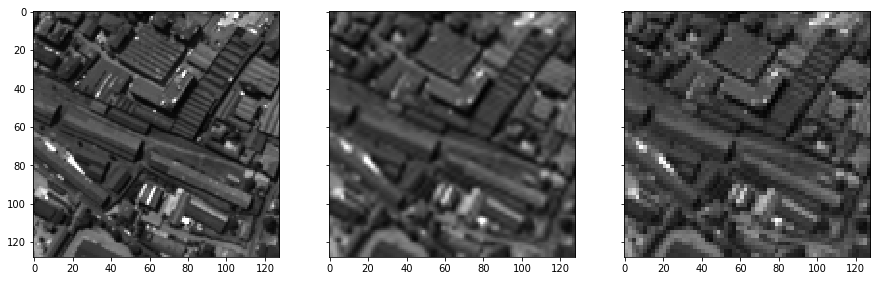

PSNR bicubic: 32.0928   PSNR nearest: 30.7085


In [2]:
file_name  = 'data/sr/sr3D.mat'

# imgs contains ['HR'] ['LR'] ['bicubic'] ['nearest']
# ensure all dimensions are divisible by 32 (or 2^(depth))!

imgs = scipy.io.loadmat(file_name)

factor = 2 

#plot band
band = 25

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(imgs['HR'][:,:,band], cmap='gray', vmin=0.0, vmax=0.5)
ax2.imshow(imgs['bicubic'][:,:,band], cmap='gray', vmin=0.0, vmax=0.5) 
ax3.imshow(imgs['nearest'][:,:,band], cmap='gray', vmin=0.0, vmax=0.5)
plt.show()

print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                    compare_psnr(imgs['HR'], imgs['bicubic']), 
                                    compare_psnr(imgs['HR'], imgs['nearest'])))

# Set up parameters and net

In [3]:
input_depth = imgs['HR'].shape[2]
 
method =    '3D'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

plot_every = 500
save_every = 2000

OPTIMIZER = 'adam'

num_iter = 10001
reg_noise_std = 0.05 # try 0 0.01 0.03 0.08


In [4]:
net_input = get_noise(input_depth, method, (imgs['HR'].shape[0], imgs['HR'].shape[1])).type(dtype).detach()

net = skip(1, 1, 
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,  
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='trilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

'''
net = skip(1, 1, 
               num_channels_down = [16, 32, 64, 128, 128, 128][:6],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:6],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:6],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
'''
# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = imgs['LR'].transpose(2,0,1)
img_LR_var = torch.from_numpy(img_LR_var).type(dtype)
img_LR_var = img_LR_var[None, None, :].cuda()

downsampler = Downsampler(n_planes=input_depth, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [5]:
def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR.squeeze(0))[None,:]

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR'].astype(np.float32), out_LR.detach().cpu().squeeze().numpy().transpose(1,2,0))
    psnr_HR = compare_psnr(imgs['HR'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1,2,0))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if i % plot_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1,2,0)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(imgs['HR'][:,:,band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(imgs['bicubic'][:,:,band], cmap='gray', vmin=0.0, vmax=0.5)
        ax3.imshow(np.clip(out_HR_np, 0, 1)[:,:,band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()
        
    if  i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1,2,0)
        scipy.io.savemat("results/result_sr_2D_it%05d_192.mat" % (i), {'pred':np.clip(out_HR_np, 0, 1)})

    i += 1
    
    return total_loss

Starting optimization with ADAM


/home/oleksii/miniconda3/envs/venv/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/oleksii/miniconda3/envs/venv/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


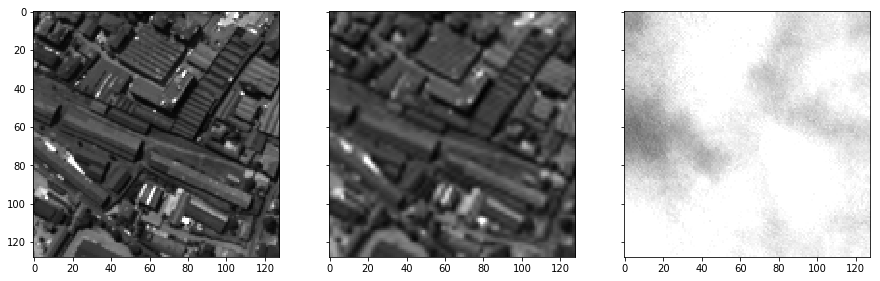

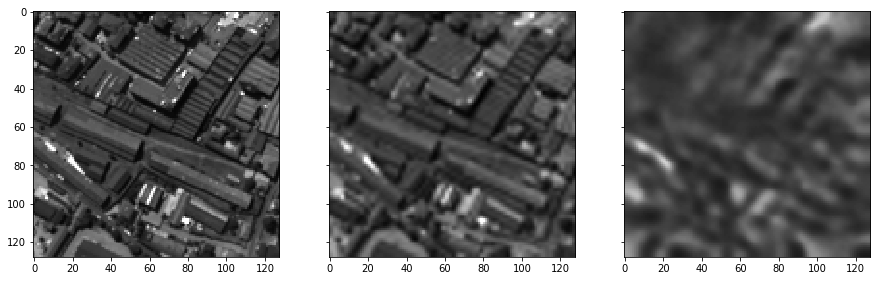

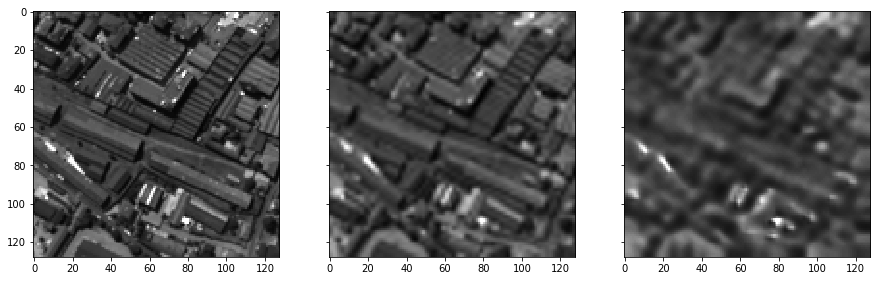

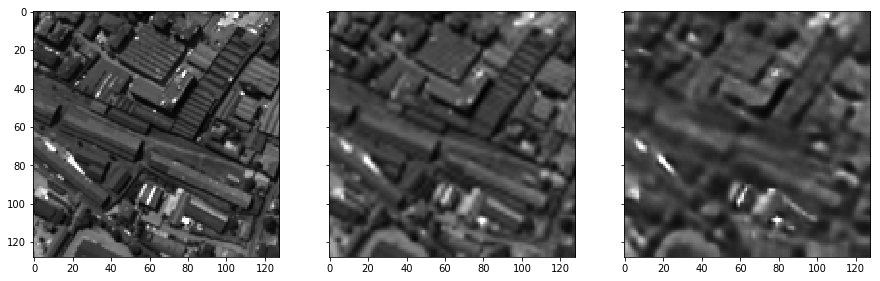

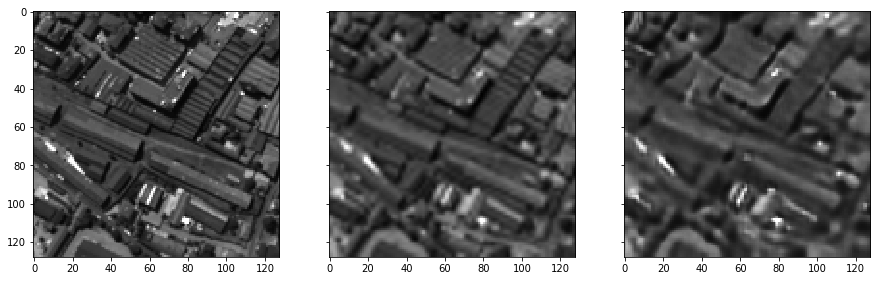

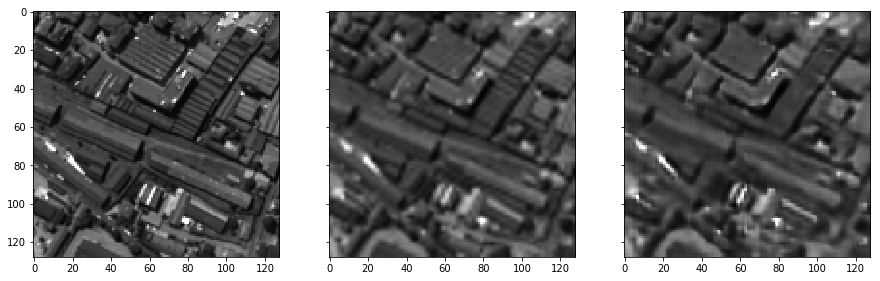

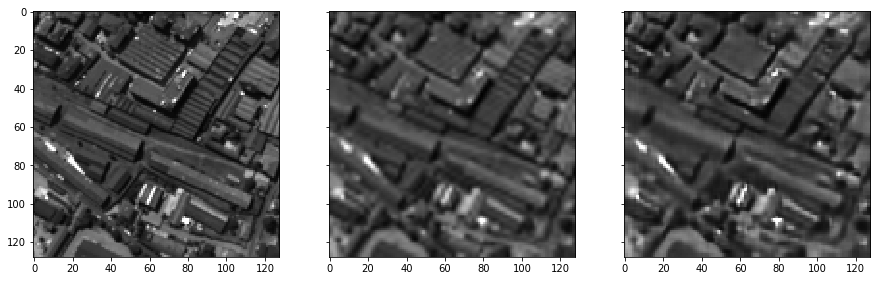

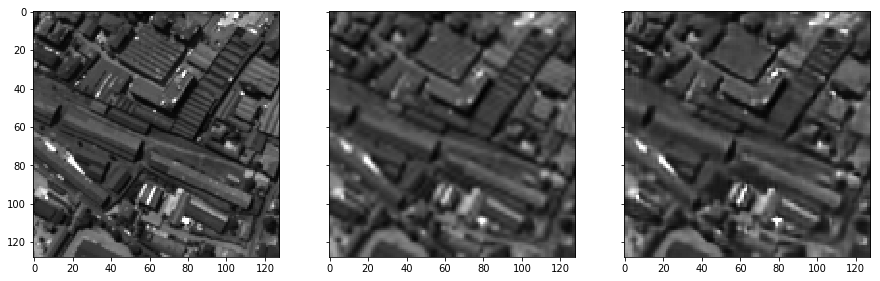

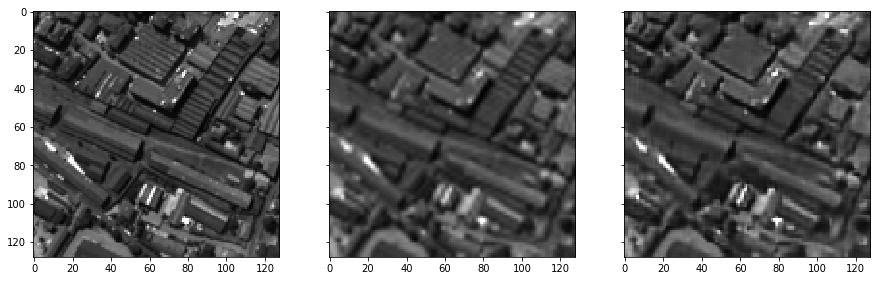

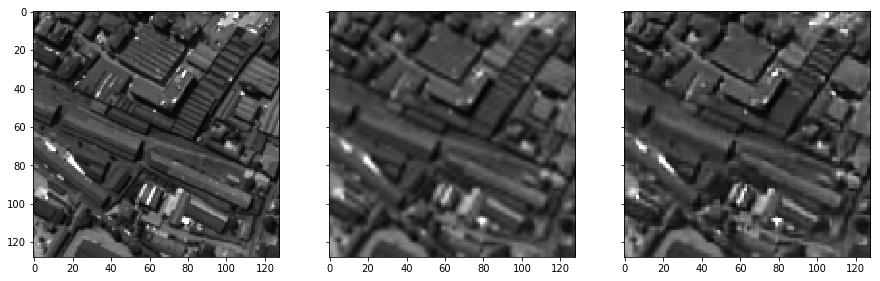

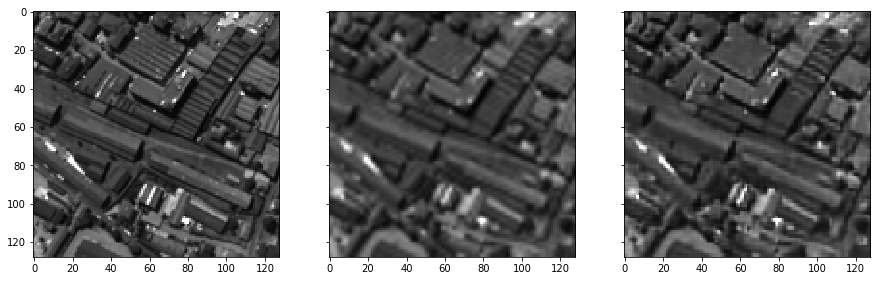

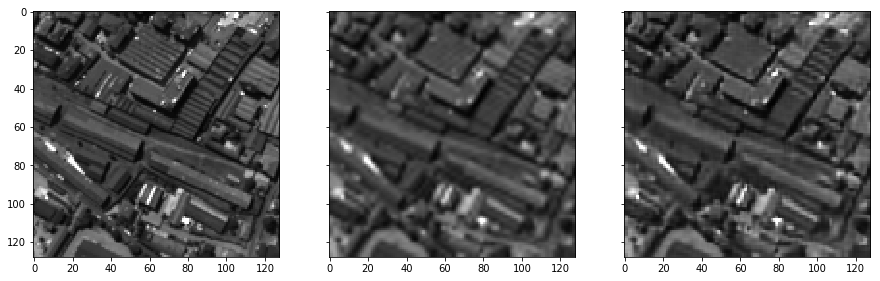

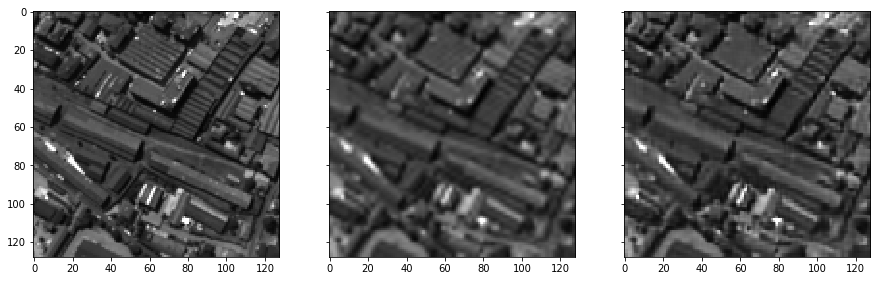

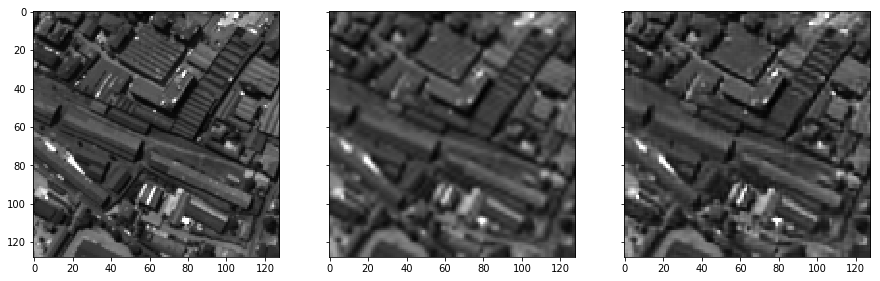

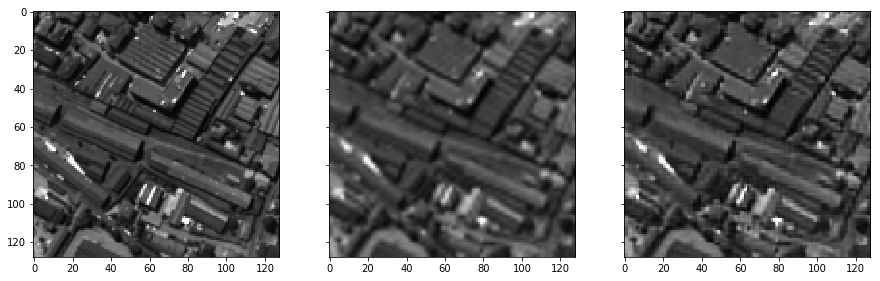

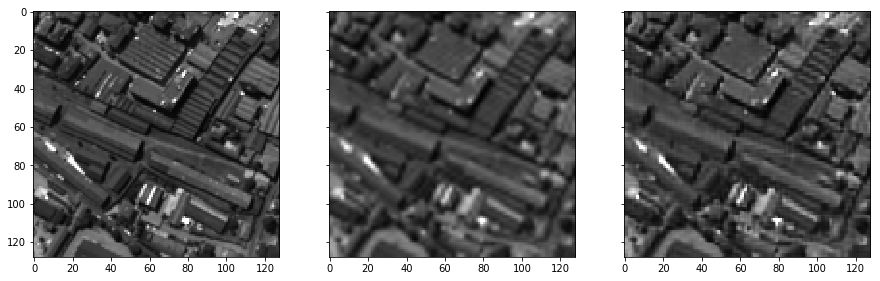

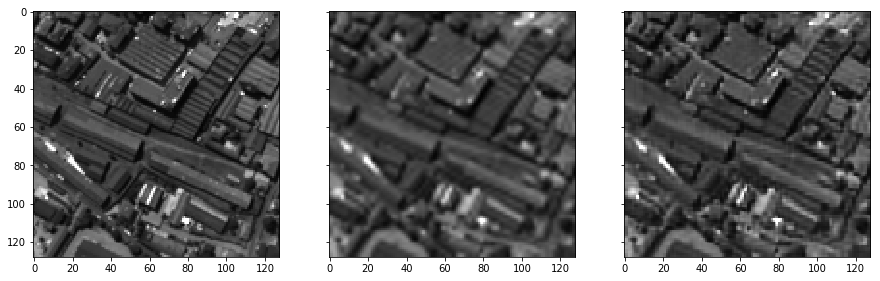

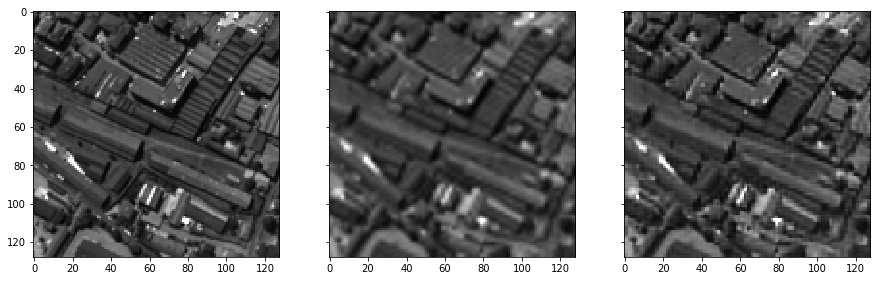

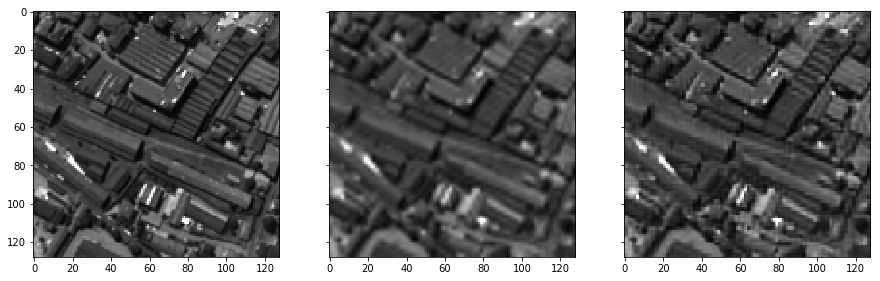

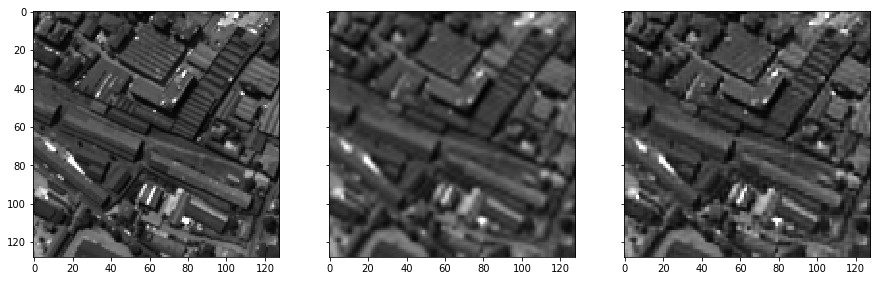

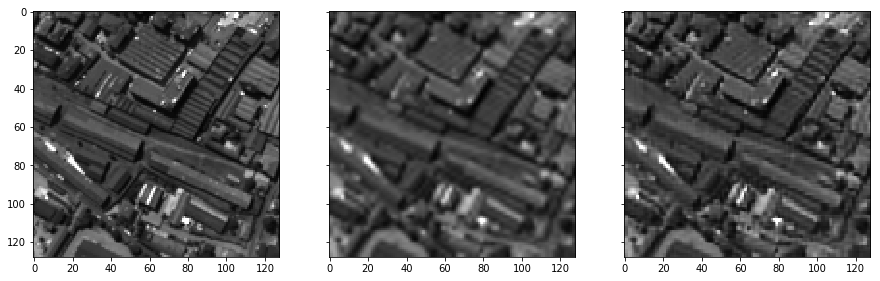

In [6]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)